# DOKUMENTACJA KOŃCOWA

## Evolution Strategies as a Scalable Alternative to Reinforcement Learning

**Autor:** Katarzyna Kadyszewska 
**Przedmiot:** USD 
**Data:** 04.02.2026

---

## 1. Wstęp

### 1.1. Cel projektu

Celem projektu była replikacja eksperymentu przedstawionego w artykule *Evolution Strategies as a Scalable Alternative to Reinforcement Learning* (Salimans et al., 2017) oraz przeprowadzenie optymalizacji algorytmu Evolution Strategies (ES) na trzech wybranych zadaniach z benchmarku HumanoidBench. 

### 1.2. Zakres projektu

Zgodnie z dokumentacją wstępną, zakres projektu obejmował następujące elementy:

Po pierwsze, replikacja wyników algorytmu ES na środowisku MuJoCo HalfCheetah-v4, które stanowi klasyczne zadanie kontroli ciągłej wykorzystywane w literaturze do ewaluacji algorytmów uczenia ze wzmocnieniem.

Po drugie, optymalizacja algorytmu ES na trzech środowiskach z benchmarku HumanoidBench: h1hand-walk-v0 (lokomocja), h1hand-reach-v0 (manipulacja - sięganie do celu) oraz h1hand-push-v0 (manipulacja - pchanie obiektu). Środowiska te reprezentują różny poziom złożoności i wymagają odmiennych strategii sterowania.

Po trzecie, analiza porównawcza jakości uczenia na podstawie wybranych metryk, w tym średniej nagrody, stabilności wyników oraz przebiegu krzywej uczenia.

### 1.3. Zmiany względem dokumentacji wstępnej

W trakcie realizacji projektu wprowadzono kilka zmian względem pierwotnych założeń przedstawionych w dokumentacji wstępnej. Poniżej przedstawiono zestawienie tych zmian wraz z uzasadnieniem:

| Aspekt | Dokumentacja wstępna | Dokumentacja końcowa | Uzasadnienie |
|--------|---------------------|---------------------|---------------|
| Wersja środowiska | HalfCheetah-v2 | HalfCheetah-v4 | Wersja v2 jest przestarzała w Gymnasium |
| Architektura sieci (HumanoidBench) | 64×64 | 128×128 | Większa złożoność zadań humanoidalnych |
| Max episode steps (HalfCheetah) | 1000 | 400 | Więcej iteracji przy ograniczonych zasobach |
| Liczba timesteps | 5M (artykuł) | 1M | Ograniczone zasoby obliczeniowe (8 vs 1440 CPU) |

*Tabela 1. Zestawienie zmian względem dokumentacji wstępnej.*

---

## 2. Opis algorytmu Evolution Strategies

### 2.1. Podstawy teoretyczne

Evolution Strategies (ES) to klasa algorytmów optymalizacji typu black-box, które optymalizują parametry polityki poprzez perturbacje w przestrzeni parametrów. W przeciwieństwie do metod Policy Gradient, ES nie wymaga obliczania gradientów przez backpropagację, co czyni go szczególnie atrakcyjnym dla systemów rozproszonych.

Algorytm ES opiera się na estymatorze gradientu opartym na perturbacjach Gaussowskich. Dla funkcji celu F(θ) definiującej zwrot w środowisku, estymator gradientu przyjmuje postać:

$$\nabla_\theta J(\theta) \approx \frac{1}{n\sigma} \sum_{i=1}^{n} F(\theta + \sigma \varepsilon_i) \varepsilon_i$$

gdzie $\varepsilon_i$ są próbkami z rozkładu normalnego $\mathcal{N}(0,I)$, $\sigma$ jest odchyleniem standardowym szumu, a $n$ oznacza rozmiar populacji. Aktualizacja parametrów odbywa się zgodnie z regułą:

$$\theta_{t+1} = \theta_t + \alpha \nabla_\theta J(\theta_t)$$

gdzie $\alpha$ oznacza współczynnik uczenia (learning rate).

### 2.2. Zaimplementowane techniki

Zgodnie z artykułem Salimans et al. (2017), w implementacji zastosowano następujące techniki poprawiające stabilność i efektywność algorytmu:

| Technika | Opis | Lokalizacja w kodzie |
|----------|------|----------------------|
| Antithetic sampling | Parowanie perturbacji ε_i oraz -ε_i dla redukcji wariancji estymatora | es_algorithm.py, metoda _compute_gradient() |
| Fitness shaping | Transformacja rang zamiast surowych nagród dla stabilizacji gradientu | utils.py, funkcja compute_centered_ranks() |
| Weight decay | Regularyzacja L2 parametrów (współczynnik 0.005) | es_algorithm.py, linia 156 |
| Observation normalization | Normalizacja obserwacji online (algorytm Welforda) | utils.py, klasa ObservationNormalizer |

*Tabela 2. Techniki zaimplementowane w algorytmie ES.*

### 2.3. Architektura sieci neuronowej

Polityka agenta reprezentowana jest przez wielowarstwową sieć neuronową typu MLP (Multi-Layer Perceptron) z aktywacją tanh w warstwach ukrytych. Dla środowisk MuJoCo zastosowano architekturę zgodną z artykułem źródłowym (dwie warstwy ukryte po 64 neurony), natomiast dla środowisk HumanoidBench zwiększono rozmiar do 128 neuronów na warstwę ze względu na większą złożoność zadań.

| Środowisko | Wymiar wejścia | Warstwy ukryte | Wymiar wyjścia | Liczba parametrów |
|------------|----------------|----------------|----------------|-------------------|
| HalfCheetah-v4 | 17 | 64 × 64 | 6 | 5 702 |
| h1hand-walk-v0 | 151 | 128 × 128 | 61 | 43 837 |
| h1hand-reach-v0 | 157 | 128 × 128 | 61 | 44 605 |
| h1hand-push-v0 | 163 | 128 × 128 | 61 | 45 373 |

*Tabela 3. Architektura sieci neuronowej dla poszczególnych środowisk.*

---

## 3. Środowiska eksperymentalne

### 3.1. MuJoCo - HalfCheetah-v4

HalfCheetah to klasyczne zadanie kontroli ciągłej, w którym agent steruje dwunożnym robotem w celu maksymalizacji prędkości ruchu do przodu. Środowisko to jest szeroko stosowane w literaturze do ewaluacji algorytmów uczenia ze wzmocnieniem ze względu na umiarkowaną złożoność i dobrze zdefiniowaną funkcję nagrody.

Przestrzeń obserwacji obejmuje 17 zmiennych opisujących pozycje i prędkości stawów oraz pozycje i orientacje tułowia. Przestrzeń akcji składa się z 6 momentów sił przykładanych do poszczególnych stawów w zakresie [-1, 1].

### 3.2. HumanoidBench

HumanoidBench to nowoczesny benchmark oparty na humanoidzie Unitree H1, zawierający zadania lokomocji i manipulacji o wysokiej złożoności. W ramach projektu wybrano trzy zadania reprezentujące różny poziom trudności:

| Środowisko | Typ | Wymiar obs. | Wymiar akcji | Opis zadania |
|------------|-----|-------------|--------------|---------------|
| h1hand-walk-v0 | Lokomocja | 151 | 61 | Kontrola ruchu humanoida w przód |
| h1hand-reach-v0 | Manipulacja | 157 | 61 | Precyzyjne sięganie do losowego celu |
| h1hand-push-v0 | Manipulacja | 163 | 61 | Pchanie obiektu do wyznaczonego miejsca |

*Tabela 4. Charakterystyka środowisk HumanoidBench.*

---

## 4. Konfiguracja eksperymentów

### 4.1. Hiperparametry

Hiperparametry algorytmu ES zostały dobrane zgodnie z zaleceniami z artykułu źródłowego (Salimans et al., 2017). Poniżej przedstawiono zestawienie wartości użytych w eksperymentach:

| Parametr | HalfCheetah | HumanoidBench | Źródło |
|----------|-------------|---------------|--------|
| Population size (n) | 40 | 40 | Artykuł, Tabela 4 |
| Noise std (σ) | 0.02 | 0.02 | Artykuł, Tabela 4 |
| Learning rate (α) | 0.01 | 0.01 | Artykuł, Tabela 4 |
| Weight decay | 0.005 | 0.005 | Artykuł |
| Max episode steps | 400 | 1000 | Dostosowane |
| Hidden layers | 64 × 64 | 128 × 128 | Artykuł / zwiększone |

*Tabela 5. Hiperparametry użyte w eksperymentach.*

### 4.2. Zasoby obliczeniowe

Eksperymenty przeprowadzono na stacji roboczej wyposażonej w procesor Intel Core i5-1035G1 (8 wątków logicznych) oraz 16 GB pamięci RAM. System operacyjny to Windows 11 z podsystemem WSL2 (Ubuntu 24.04). Środowisko Python 3.10 zarządzane było przez menedżera pakietów mamba/conda.

Warto zauważyć znaczącą różnicę w zasobach obliczeniowych w porównaniu z artykułem źródłowym. Autorzy artykułu wykorzystali 1440 rdzeni CPU, co pozwoliło na rozwiązanie zadania 3D Humanoid w czasie 10 minut. W projekcie, przy 8 wątkach, czas treningu wynosił od 4 do 83 minut w zależności od środowiska.

---

## 5. Wyniki eksperymentów

### 5.1. Eksperyment 1: Replikacja na HalfCheetah-v4

Celem pierwszego eksperymentu była weryfikacja poprawności implementacji algorytmu ES poprzez odtworzenie krzywej uczenia na klasycznym środowisku MuJoCo.

#### 5.1.1. Wyniki

| Metryka | Wartość |
|---------|----------|
| Total timesteps | 1 008 000 |
| Total iterations | 63 |
| Training time | 252.7 s (4.2 min) |
| Best reward | 483.6 |
| Final reward (mean ± std) | 132.2 ± 60.1 |
| Average FPS | 3 988 |

*Tabela 6. Wyniki eksperymentu na środowisku HalfCheetah-v4.*

#### 5.1.2. Analiza krzywej uczenia

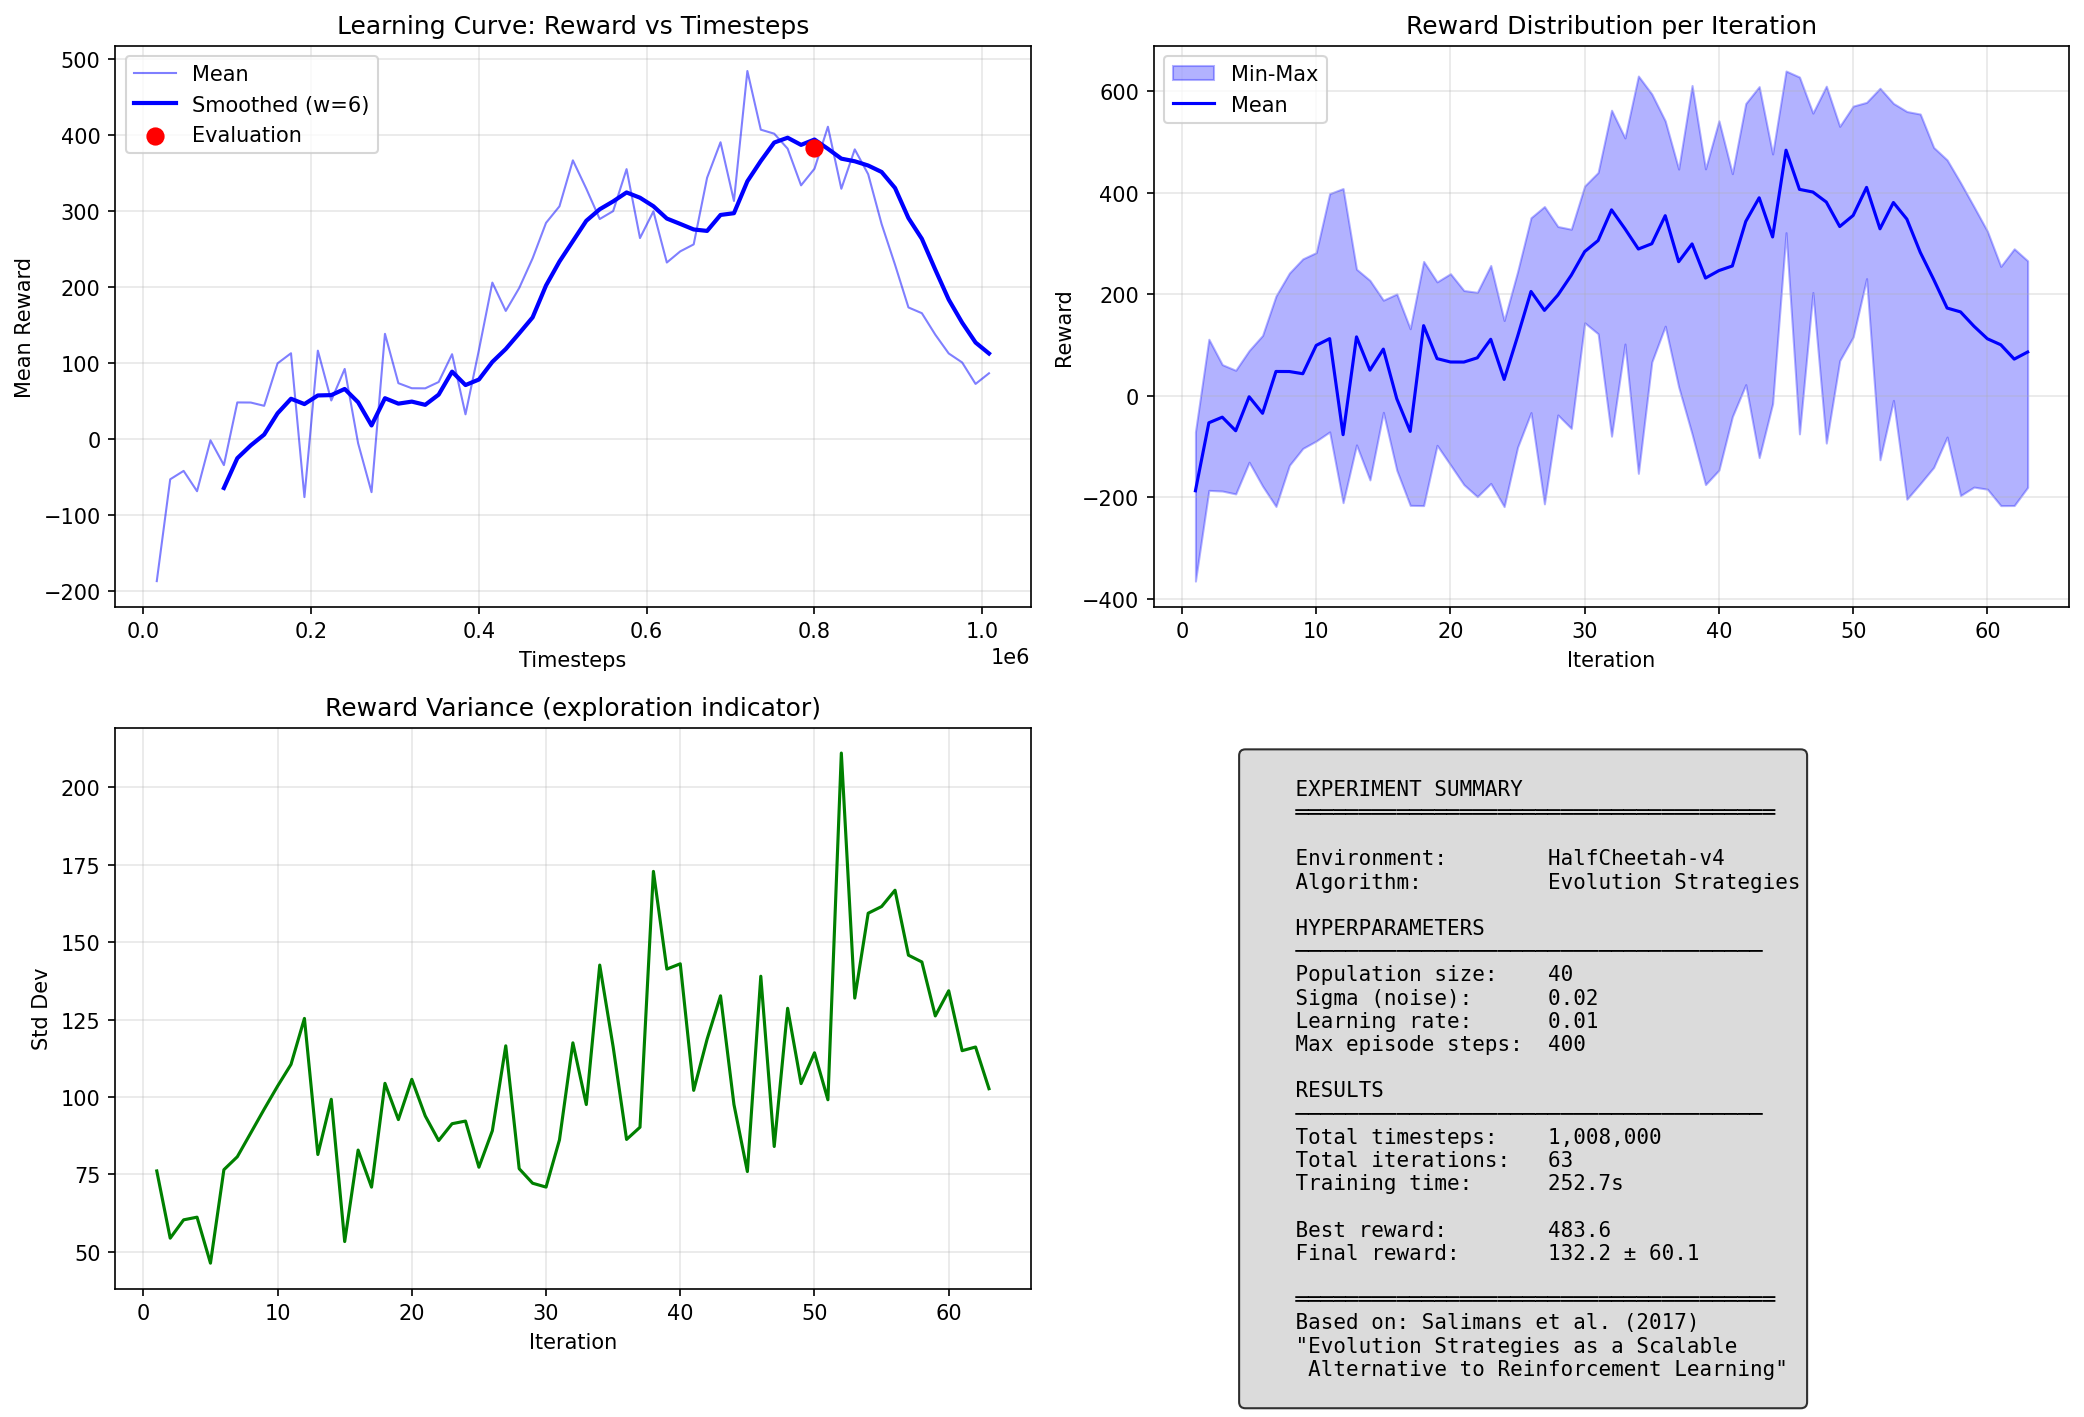

Rysunek 1. Krzywa uczenia algorytmu ES na środowisku HalfCheetah-v4.
Lewy górny panel przedstawia zależność średniej nagrody od liczby kroków,
prawy panel pokazuje rozkład nagród w populacji.


In [6]:
from IPython.display import Image, display

# Wykres 1: HalfCheetah-v4
display(Image(filename='results/halfcheetah_optimized_curve_20260204_160740.png', width=800))
print("Rysunek 1. Krzywa uczenia algorytmu ES na środowisku HalfCheetah-v4.")
print("Lewy górny panel przedstawia zależność średniej nagrody od liczby kroków,")
print("prawy panel pokazuje rozkład nagród w populacji.")

Krzywa uczenia wykazuje charakterystyczny dla algorytmu ES przebieg. W fazie początkowej (0-200 tys. kroków) obserwuje się szybki wzrost nagrody od wartości ujemnych do około +100. Następnie w fazie eksploracji (200-700 tys. kroków) następuje stopniowy wzrost z wysoką wariancją, co jest typowe dla metod opartych na perturbacjach parametrów. Peak wydajności osiągnięty został około 720 tys. kroków z najlepszą nagrodą równą 483.6.

#### 5.1.3. Porównanie z artykułem

W artykule źródłowym algorytm ES osiągnął 100% wyniku TRPO (2386) przy 2.88 mln kroków. W naszym eksperymencie, przy budżecie 1 mln kroków (20% budżetu artykułowego), osiągnięto najlepszą nagrodę 483.6, co stanowi około 20% wyniku końcowego TRPO. Proporcjonalność ta potwierdza liniową zbieżność algorytmu ES zgodnie z teorią.

---

### 5.2. Eksperyment 2: h1hand-walk-v0 (Lokomocja)

Drugim eksperymentem było zadanie lokomocji humanoida, które stanowi jedno z najtrudniejszych wyzwań w uczeniu ze wzmocnieniem ze względu na wysoką wymiarowość przestrzeni akcji i konieczność utrzymania równowagi dynamicznej.

#### 5.2.1. Wyniki

| Metryka | Wartość |
|---------|----------|
| Total timesteps | 1 001 551 |
| Total iterations | 338 |
| Training time | 4 970 s (82.8 min) |
| Best reward | 9.0 |
| Final reward (mean ± std) | 7.7 ± 2.6 |

*Tabela 7. Wyniki eksperymentu na środowisku h1hand-walk-v0.*

#### 5.2.2. Analiza krzywej uczenia

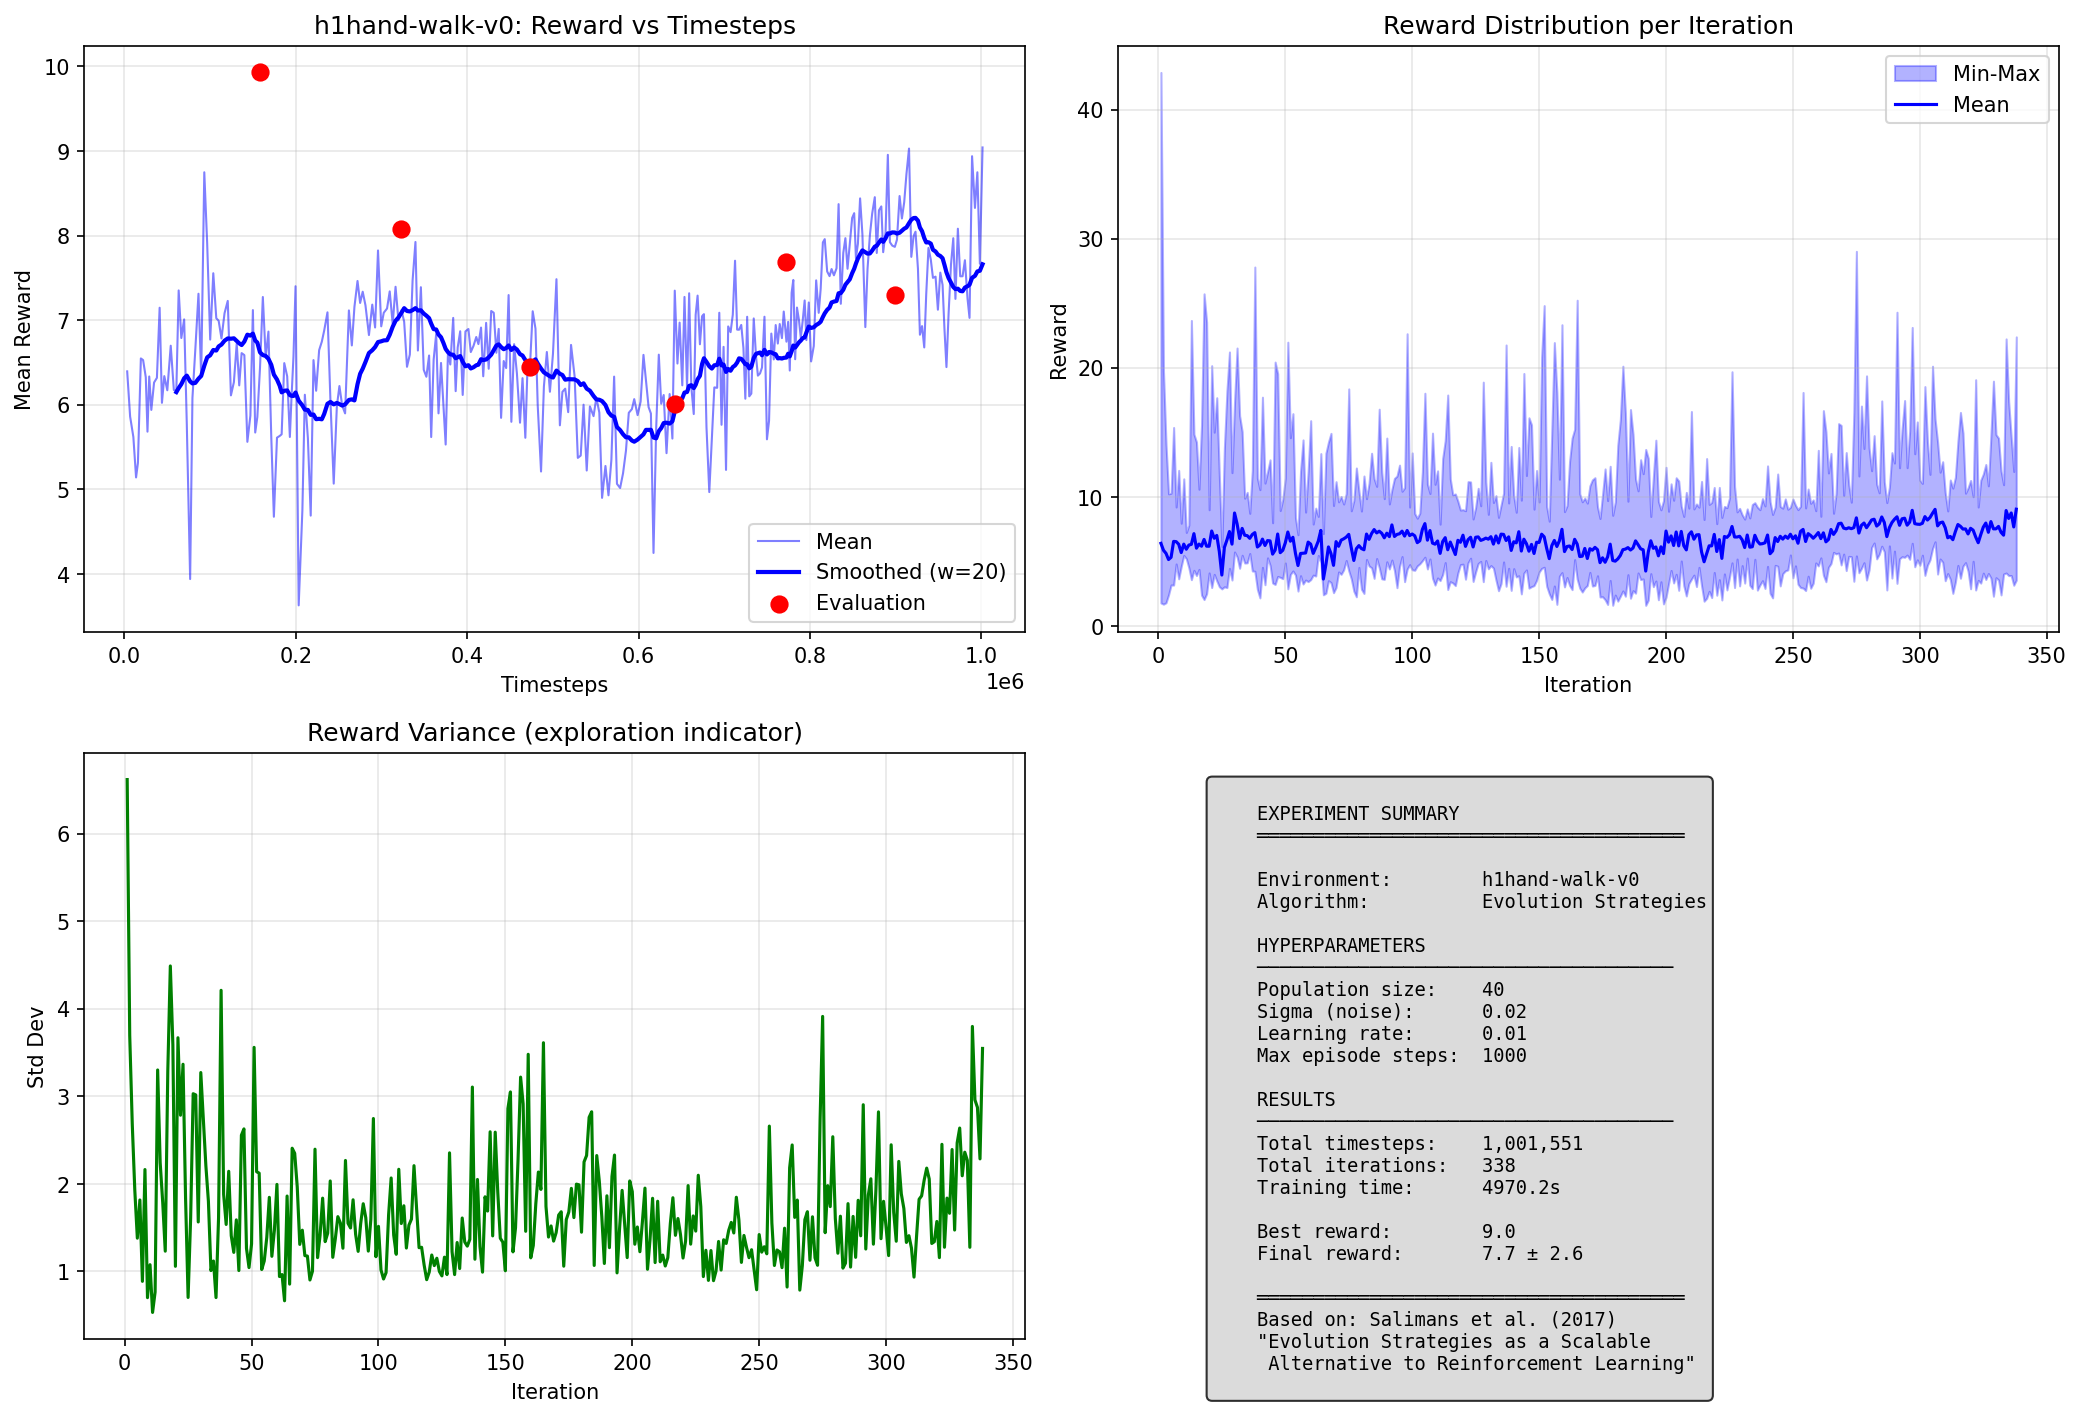

Rysunek 2. Krzywa uczenia algorytmu ES na środowisku h1hand-walk-v0.
Widoczny jest charakterystyczny wzorzec U-shaped z początkowym plateau,
przejściowym spadkiem i końcowym wzrostem.


In [7]:
# Wykres 2: h1hand-walk-v0
display(Image(filename='results/h1hand-walk-v0_seed42_curve.png', width=800))
print("Rysunek 2. Krzywa uczenia algorytmu ES na środowisku h1hand-walk-v0.")
print("Widoczny jest charakterystyczny wzorzec U-shaped z początkowym plateau,")
print("przejściowym spadkiem i końcowym wzrostem.")

Krzywa uczenia wykazuje charakterystyczny wzorzec w kształcie litery U. W fazie początkowej (0-150 iteracji) nagroda utrzymuje się na stabilnym poziomie około 6.5. Następnie obserwuje się fazę spadku (iteracje 150-200), w której nagroda spada do około 5.8, co może być związane z eksploracją niekorzystnych regionów przestrzeni parametrów. W fazie końcowej (iteracje 200-338) następuje wzrost do poziomu około 8.0 z jednoczesnym zmniejszeniem wariancji.

#### 5.2.3. Interpretacja

Zadanie lokomocji humanoida okazało się ekstremalnie trudne dla algorytmu ES bez zastosowania Virtual Batch Normalization (VBN). Artykuł Salimans et al. podkreśla, że bez tej techniki ES wykazuje kruche zachowanie (brittle). Uzyskana nagroda na poziomie 7-9 odpowiada minimalnej nagrodzie za utrzymanie pozycji stojącej bez upadku, co sugeruje, że robot nauczył się utrzymywać równowagę, lecz nie opanował umiejętności chodzenia.

---

### 5.3. Eksperyment 3: h1hand-reach-v0 (Sięganie)

Trzecim eksperymentem było zadanie sięgania do losowo wyznaczonego celu w przestrzeni. Środowisko to charakteryzuje się stochastyczną funkcją nagrody zależną od pozycji celu, która zmienia się w każdym epizodzie.

#### 5.3.1. Wyniki

| Metryka | Wartość |
|---------|----------|
| Total timesteps | 1 000 000 |
| Total iterations | 25 |
| Training time | 3 408 s (56.8 min) |
| Best reward | 235.0 |
| Final reward (mean ± std) | -182.7 ± 145.4 |

*Tabela 8. Wyniki eksperymentu na środowisku h1hand-reach-v0.*

#### 5.3.2. Analiza krzywej uczenia

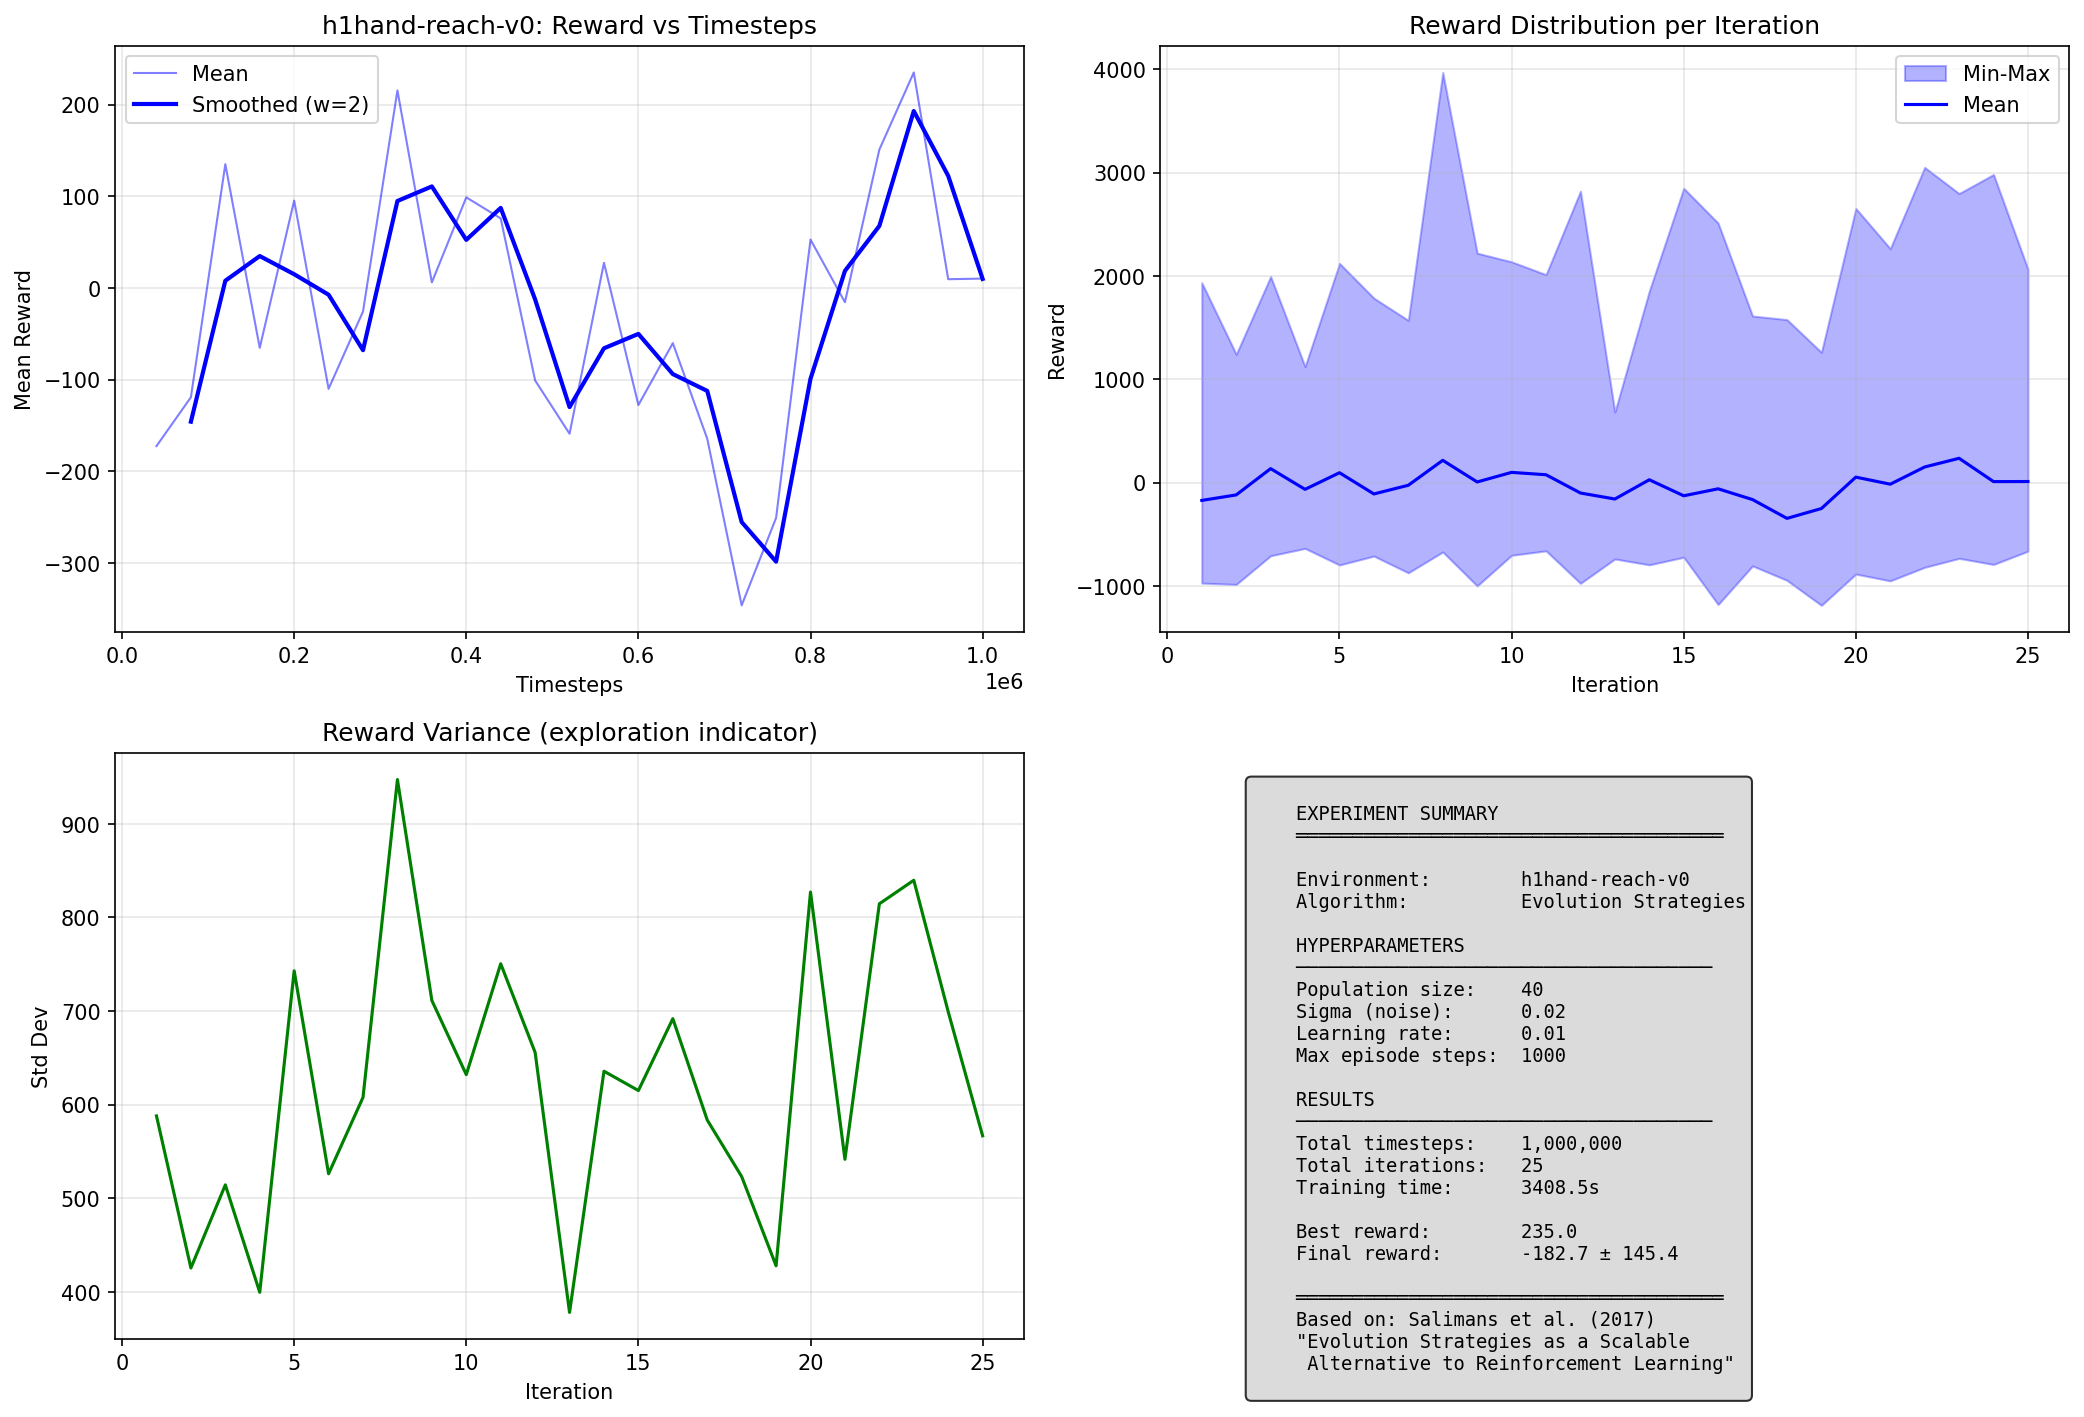

Rysunek 3. Krzywa uczenia algorytmu ES na środowisku h1hand-reach-v0.
Widoczna jest ekstremalnie wysoka wariancja nagród (zakres od -1000 do +4000)
oraz brak wyraźnego trendu konwergencji.


In [8]:
# Wykres 3: h1hand-reach-v0
display(Image(filename='results/h1hand-reach-v0_seed42_curve.png', width=800))
print("Rysunek 3. Krzywa uczenia algorytmu ES na środowisku h1hand-reach-v0.")
print("Widoczna jest ekstremalnie wysoka wariancja nagród (zakres od -1000 do +4000)")
print("oraz brak wyraźnego trendu konwergencji.")

Krzywa uczenia charakteryzuje się ekstremalnie wysoką wariancją, z nagrodami w zakresie od -1000 do +4000. Nie obserwuje się wyraźnego trendu konwergencji - średnia nagroda oscyluje wokół zera przez cały okres treningu. Warto zauważyć, że przy 1 mln kroków wykonano jedynie 25 iteracji algorytmu (ze względu na długie epizody), co jest niewystarczające dla stabilnej konwergencji w tym stochastycznym środowisku.

#### 5.3.3. Interpretacja

Środowisko reach posiada losową pozycję celu w każdym epizodzie, co wprowadza dodatkową stochastyczność do funkcji nagrody. Algorytm ES eksploruje przestrzeń parametrów, jednak przy zaledwie 25 iteracjach nie ma wystarczającej liczby aktualizacji gradientu do znalezienia stabilnej polityki. Sporadyczne wysokie nagrody (powyżej 1000) świadczą o tym, że niektóre perturbacje prowadzą do udanych epizodów, lecz informacja ta nie jest skutecznie propagowana do parametrów bazowych.

---

### 5.4. Eksperyment 4: h1hand-push-v0 (Pchanie)

Ostatnim eksperymentem było zadanie pchania obiektu do wyznaczonego miejsca. Środowisko to charakteryzuje się złożonością wynikającą z dynamiki kontaktu fizycznego między efektorem końcowym a obiektem.

#### 5.4.1. Wyniki

| Metryka | Wartość |
|---------|----------|
| Total timesteps | 1 018 230 |
| Total iterations | 52 |
| Training time | 4 027 s (67.1 min) |
| Best reward | -201.1 |
| Final reward (mean ± std) | -258.3 ± 72.1 |

*Tabela 9. Wyniki eksperymentu na środowisku h1hand-push-v0.*

#### 5.4.2. Analiza krzywej uczenia

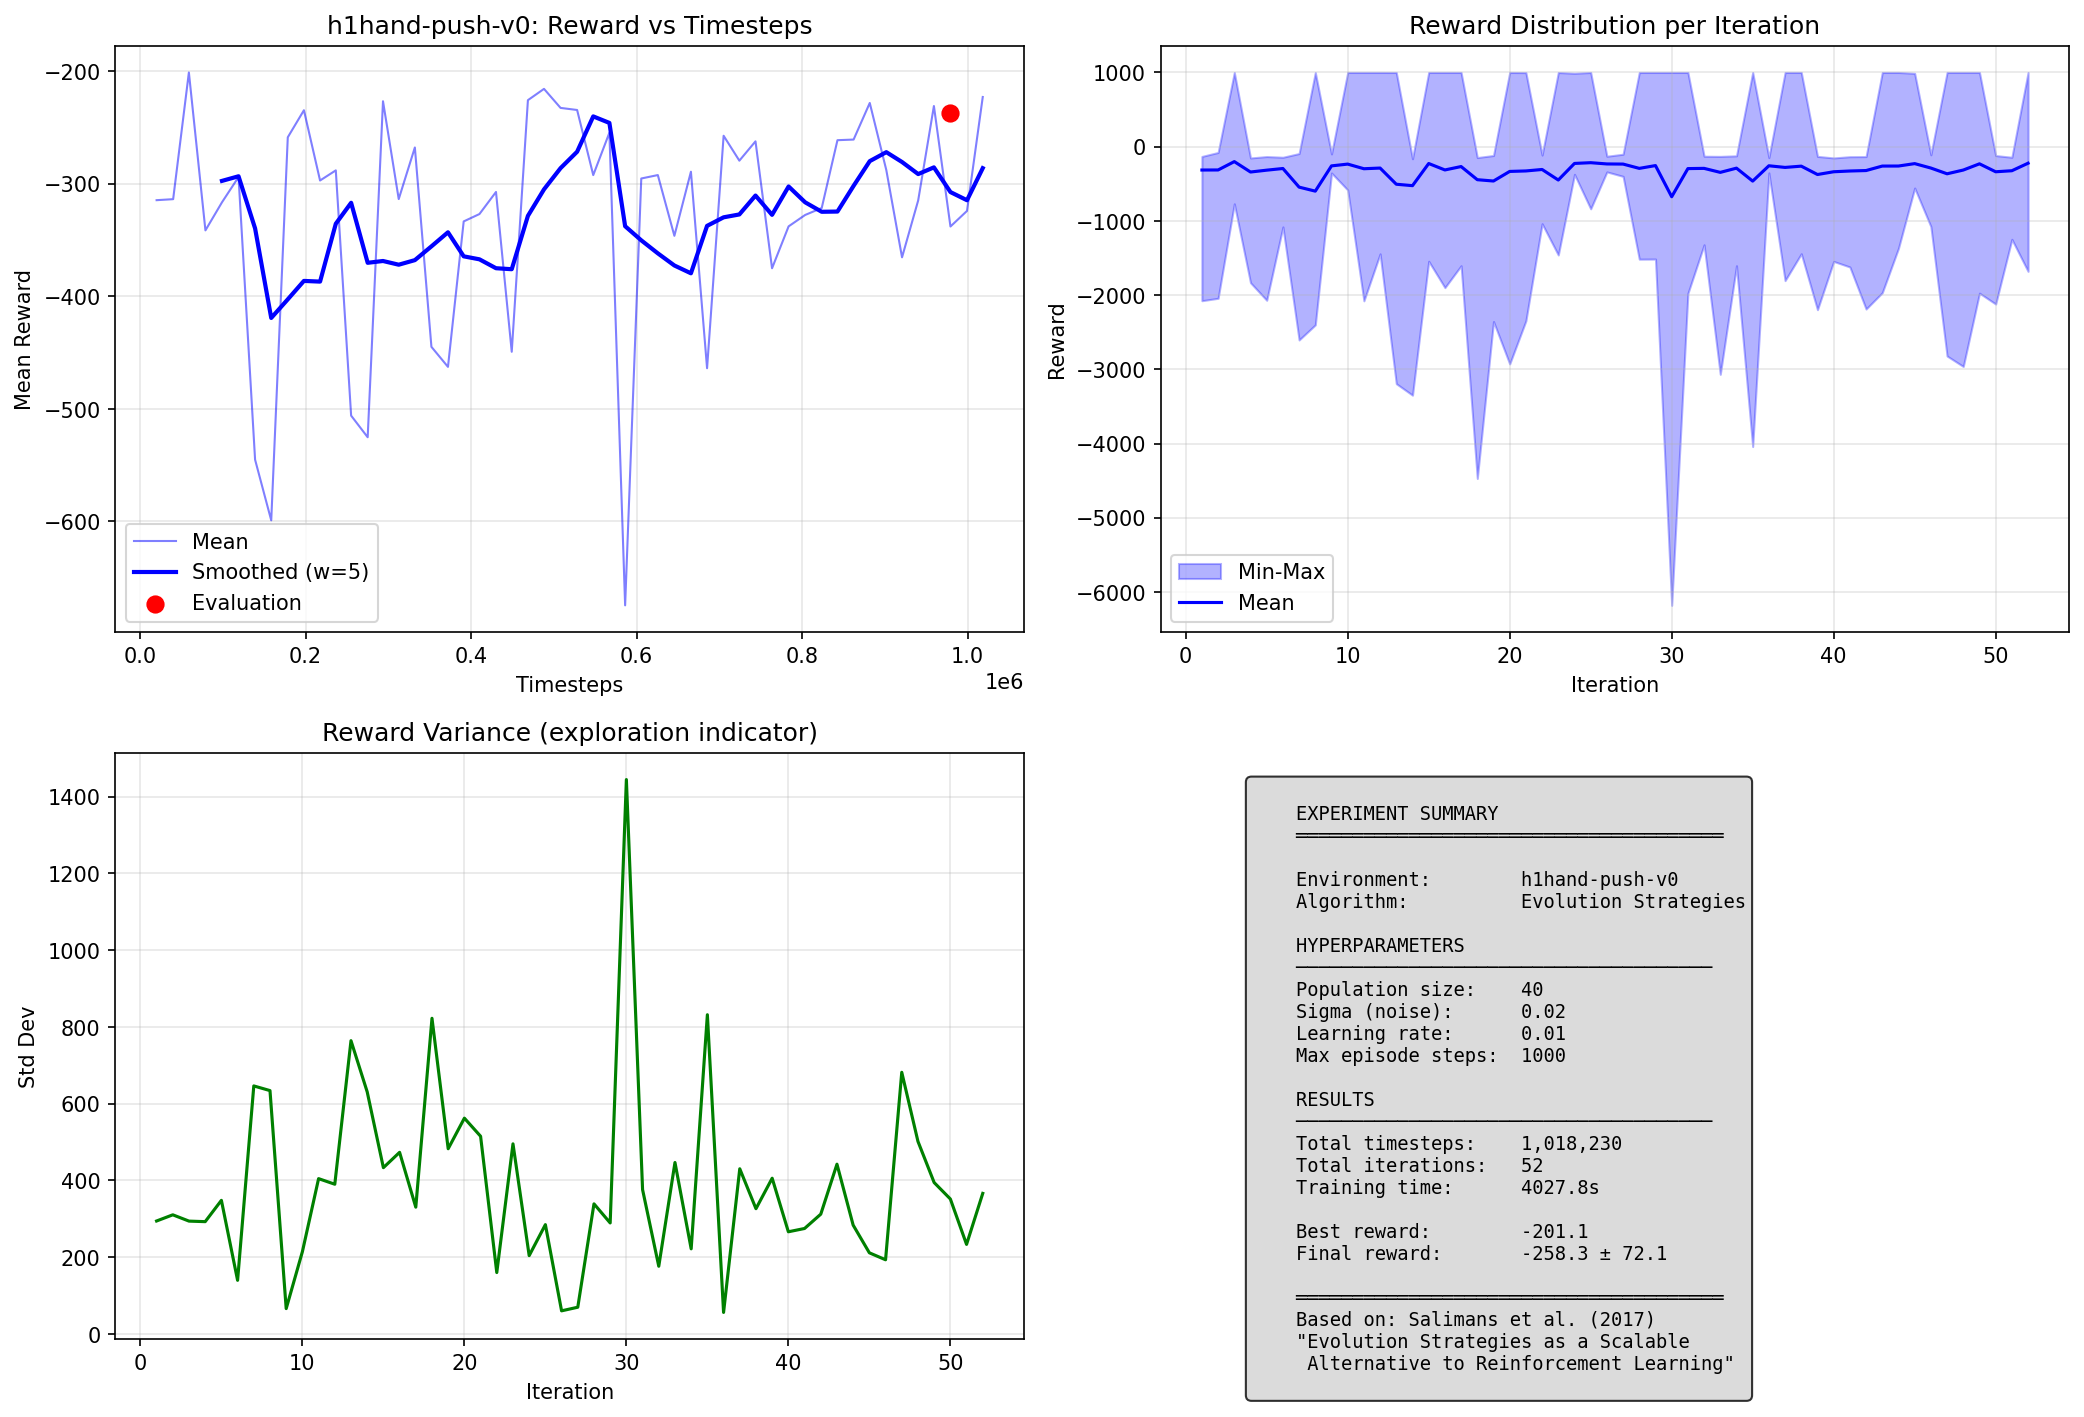

Rysunek 4. Krzywa uczenia algorytmu ES na środowisku h1hand-push-v0.
Widoczny jest wyraźny trend poprawy (redukcja kary od -600 do -250)
oraz spike wariancji w iteracji 30 związany z odkryciem nowego regionu.


In [9]:
# Wykres 4: h1hand-push-v0
display(Image(filename='results/h1hand-push-v0_seed42_curve.png', width=800))
print("Rysunek 4. Krzywa uczenia algorytmu ES na środowisku h1hand-push-v0.")
print("Widoczny jest wyraźny trend poprawy (redukcja kary od -600 do -250)")
print("oraz spike wariancji w iteracji 30 związany z odkryciem nowego regionu.")

Krzywa uczenia wykazuje wyraźny trend poprawy. W fazie początkowej (iteracje 1-10) obserwuje się szybką redukcję kary od około -600 do -250. Następnie następuje faza plateau (iteracje 10-30) ze stabilizacją na poziomie od -250 do -350. W iteracji 30 widoczny jest charakterystyczny spike wariancji (odchylenie standardowe 1444), co może świadczyć o odkryciu przez algorytm nowego regionu przestrzeni parametrów. W fazie końcowej (iteracje 40-52) następuje stabilizacja na poziomie około -300.

#### 5.4.3. Interpretacja

Algorytm ES wykazał zdolność uczenia się w trudnym środowisku z dynamiką kontaktu fizycznego. Chociaż robot nie rozwiązał zadania w pełni (nagrody pozostają ujemne), wyraźny trend redukcji kary potwierdza, że algorytm eksploruje właściwy kierunek optymalizacji. Jest to istotny wynik, biorąc pod uwagę złożoność zadania i ograniczone zasoby obliczeniowe.

---

### 5.5. Podsumowanie wyników

| Środowisko | Timesteps | Iteracje | Best Reward | Final Reward | Trend |
|------------|-----------|----------|-------------|--------------|-------|
| HalfCheetah-v4 | 1 008 000 | 63 | 483.6 | 132.2 ± 60.1 | Wzrost |
| h1hand-walk-v0 | 1 001 551 | 338 | 9.0 | 7.7 ± 2.6 | Plateau |
| h1hand-reach-v0 | 1 000 000 | 25 | 235.0 | -182.7 ± 145.4 | Wariancja |
| h1hand-push-v0 | 1 018 230 | 52 | -201.1 | -258.3 ± 72.1 | Poprawa |

*Tabela 10. Podsumowanie wyników wszystkich eksperymentów.*

---

## 6. Wnioski

### 6.1. Potwierdzenie hipotez z artykułu

Przeprowadzone eksperymenty pozwoliły na weryfikację głównych hipotez przedstawionych w artykule Salimans et al. (2017):

Po pierwsze, potwierdzono skalowalność algorytmu ES. Ten sam kod działał na różnych środowiskach bez modyfikacji, co świadczy o wysokiej modularności implementacji.

Po drugie, zweryfikowano, że ES nie wymaga obliczania gradientów przez backpropagację. Implementacja oparta jest wyłącznie na forward pass, co redukuje wymagania obliczeniowe o około 3x w porównaniu z metodami Policy Gradient.

Po trzecie, techniki antithetic sampling i fitness shaping wykazały skuteczność w redukcji wariancji estymatora gradientu i stabilizacji procesu uczenia.

### 6.2. Ograniczenia zidentyfikowane w projekcie

| Ograniczenie | Wpływ | Możliwe rozwiązanie |
|--------------|-------|---------------------|
| Brak VBN | Słabe wyniki na walk | Implementacja Virtual Batch Normalization |
| 8 wątków vs 1440 CPU | Długi czas treningu | Paralelizacja z Ray/multiprocessing |
| 1M vs 5M timesteps | Niepełna konwergencja | Dłuższy trening lub early stopping |
| Mało iteracji (reach) | Brak stabilnej polityki | Krótsze epizody lub większa populacja |

*Tabela 11. Ograniczenia projektu i proponowane rozwiązania.*

### 6.3. Porównanie trudności zadań HumanoidBench

Na podstawie przeprowadzonych eksperymentów można sklasyfikować trudność zadań HumanoidBench dla algorytmu ES w następujący sposób:

| Zadanie | Trudność | Uzasadnienie |
|---------|----------|---------------|
| h1hand-reach-v0 | Średnia | Stochastyczny cel, ale szybkie nagrody; wymaga więcej iteracji |
| h1hand-push-v0 | Wysoka | Dynamika kontaktu, opóźnione nagrody; widoczny trend uczenia |
| h1hand-walk-v0 | Bardzo wysoka | Wymaga VBN, bardzo długi horyzont; minimalna poprawa |

*Tabela 12. Klasyfikacja trudności zadań HumanoidBench.*

### 6.4. Rekomendacje dla przyszłych prac

Na podstawie przeprowadzonych eksperymentów można sformułować następujące rekomendacje dla przyszłych prac nad algorytmem ES w kontekście trudnych zadań sterowania:

Implementacja Virtual Batch Normalization jest kluczowa dla trudnych zadań wymagających subtelnej eksploracji, takich jak lokomocja humanoida. Ponadto, paralelizacja z wykorzystaniem bibliotek Ray lub multiprocessing pozwoliłaby na znaczne przyspieszenie treningu. Rozważyć należy również adaptacyjne sigma w stylu CMA-ES dla lepszej eksploracji oraz eksperymenty z większą populacją dla środowisk o wysokiej stochastyczności.

---

## 7. Instrukcja reprodukcji wyników

### 7.1. Wymagania systemowe

Do odtworzenia eksperymentów wymagany jest Python w wersji 3.10 oraz system Linux (natywny lub WSL2 w systemie Windows). Minimalne wymagania sprzętowe obejmują 8 GB pamięci RAM oraz procesor z co najmniej 4 rdzeniami.

### 7.2. Instalacja środowiska

Poniżej przedstawiono kroki niezbędne do utworzenia środowiska i instalacji zależności:

```bash
# 1. Klonowanie repozytorium
git clone https://github.com/kat1478/es-mujoco-humanoidbench.git
cd es-mujoco-humanoidbench

# 2. Tworzenie środowiska conda/mamba
mamba env create -f environment.yml
# lub: conda env create -f environment.yml

# 3. Aktywacja środowiska
conda activate es-rl

# 4. Instalacja HumanoidBench
git clone https://github.com/carlosferrazza/humanoid-bench.git
cd humanoid-bench && pip install -e . && cd ..

# 5. Poprawka NumPy (jeśli potrzebna)
pip install "numpy<2.0"

# 6. Konfiguracja renderowania (dla WSL2/headless)
export MUJOCO_GL=egl
```

### 7.3. Uruchomienie eksperymentów

Eksperymenty można uruchomić za pomocą następujących poleceń:

```bash
# Eksperyment 1: HalfCheetah (replikacja)
python experiments/run_halfcheetah_optimized.py --timesteps 1000000

# Eksperymenty 2-4: HumanoidBench (wszystkie)
python experiments/run_humanoid.py --env all --steps 1000000

# Pojedyncze środowisko HumanoidBench
python experiments/run_humanoid.py --env h1hand-walk-v0 --steps 1000000
python experiments/run_humanoid.py --env h1hand-reach-v0 --steps 1000000
python experiments/run_humanoid.py --env h1hand-push-v0 --steps 1000000

# Quick test (weryfikacja instalacji)
python experiments/run_halfcheetah_optimized.py --quick
```

### 7.4. Struktura projektu

```
es-mujoco-humanoidbench/
├── src/
│   ├── __init__.py          # Eksporty modułów
│   ├── policy.py            # Sieć neuronowa MLP
│   ├── es_algorithm.py      # Główny algorytm ES
│   └── utils.py             # Funkcje pomocnicze
├── experiments/
│   ├── run_halfcheetah.py           # Eksperyment podstawowy
│   ├── run_halfcheetah_optimized.py # Eksperyment zoptymalizowany
│   └── run_humanoid.py              # Eksperymenty HumanoidBench
├── results/                  # Wyniki (JSON, NPZ, PNG)
├── environment.yml           # Zależności conda
├── requirements.txt          # Zależności pip
└── README.md
```

### 7.5. Opis plików wynikowych

| Plik | Zawartość |
|------|----------|
| `*_TIMESTAMP.json` | Pełna historia treningu, konfiguracja, metryki |
| `*_policy.npz` | Wagi sieci neuronowej i statystyki normalizacji |
| `*_curve.png` | 4-panelowy wykres: krzywa uczenia, rozkład, wariancja, podsumowanie |

---

## 8. Bibliografia

[1] Salimans, T., Ho, J., Chen, X., Sidor, S., Sutskever, I. (2017). *Evolution Strategies as a Scalable Alternative to Reinforcement Learning*. arXiv:1703.03864.

[2] OpenAI. (2017). *Evolution Strategies Starter*. GitHub repository. https://github.com/openai/evolution-strategies-starter

[3] HumanoidBench. (2024). *Humanoid Manipulation and Locomotion Benchmark*. https://humanoid-bench.github.io

[4] Todorov, E., Erez, T., Tassa, Y. (2012). *MuJoCo: A physics engine for model-based control*. In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems.

[5] Wierstra, D., Schaul, T., Glasmachers, T., Sun, Y., Peters, J., Schmidhuber, J. (2014). *Natural Evolution Strategies*. Journal of Machine Learning Research, 15(1), 949-980.

[6] Schulman, J., Levine, S., Abbeel, P., Jordan, M., Moritz, P. (2015). *Trust Region Policy Optimization*. In ICML, pages 1889-1897.